# 라이브러리 준비

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

# 데이터 준비
- 원본 출처: https://www.kaggle.com/c/dogs-vs-cats/data
- 실습 이미지는 원본 데이터보다 크기가 작음
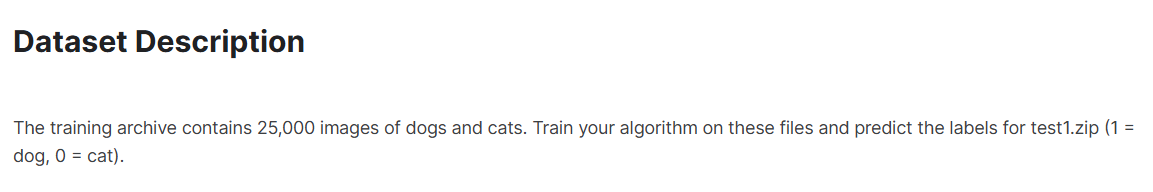

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
print(path_to_zip)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
path

/root/.keras/datasets/cats_and_dogs.zip


'/root/.keras/datasets/cats_and_dogs_filtered'

train 데이터와 validation 데이터에서 개와 고양이 이미지가 저장된 경로를 각각 변수에 저장해 둡니다.

In [4]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [5]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# 데이터 증식

기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성하되 같은 데이터를 두 번 만나지 않도록 한다. 모델이 데이터의 여러 측면을 학습하므로 일반화 성능이 높아질 것이다.

## 이미지 제너레이터 설계

In [33]:
# 학습 이미지 제너레이터
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.1,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

## 제너레이터 생성

In [34]:
# 제너레이터 관련 매개변수
batch_size = 32   # 16 -> 32
IMG_HEIGHT = 256
IMG_WIDTH  = 256


# 학습용 이미지 제너레이터 생성
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')    # cats, dogs

Found 2000 images belonging to 2 classes.


In [9]:
train_data_gen

In [35]:
# 검증용 이미지 제너레이터 설계
image_gen_val = ImageDataGenerator(rescale=1./255)

In [36]:
# 검증용 이미지 제너레이터 생성
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [12]:
val_data_gen

# VGG16 모델 구현하기
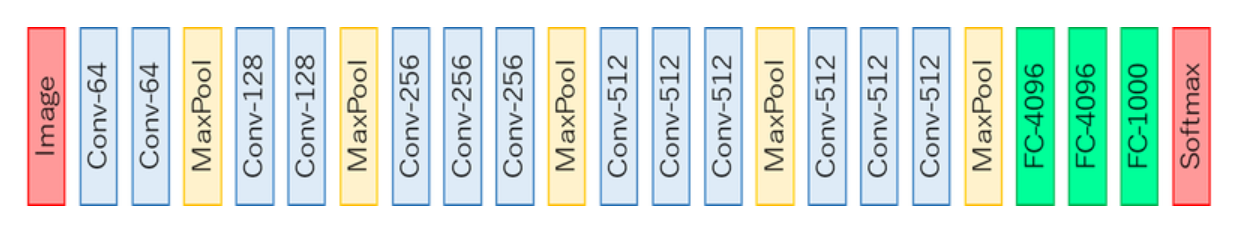

### 층 구성

In [37]:
input_layer=tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))


conv1=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
conv2=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(conv1)
conv2=tf.keras.layers.BatchNormalization()(conv2)
max1=tf.keras.layers.MaxPool2D((2, 2))(conv2)


conv3=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(max1)
conv4=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(conv3)
conv4=tf.keras.layers.BatchNormalization()(conv4)
max2=tf.keras.layers.MaxPool2D((2, 2))(conv4)


conv5=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(max2)
conv6=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv5)
conv7=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv6)
conv7=tf.keras.layers.BatchNormalization()(conv7)
max3=tf.keras.layers.MaxPool2D((2, 2))(conv7)


conv8=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(max3)
conv9=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv8)
conv10=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv9)
conv10=tf.keras.layers.BatchNormalization()(conv10)
max4=tf.keras.layers.MaxPool2D((2, 2))(conv10)


conv11=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(max4)
conv12=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv11)
conv13=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv12)
conv13=tf.keras.layers.BatchNormalization()(conv13)
max5=tf.keras.layers.MaxPool2D((2, 2))(conv13)


features=tf.keras.layers.Flatten()(max5)
f4096=tf.keras.layers.Dense(1024, activation='relu')(features)
f4096=tf.keras.layers.Dense(1024, activation='relu')(f4096)
f1000=tf.keras.layers.Dense(512, activation='relu')(f4096)
#f1000=tf.keras.layers.Dropout(0.5)(f1000)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(f1000)


model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_15 (Ba  (None, 256, 256, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 128)     7385

### 하이퍼 파라미터 설정

In [38]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='convent_from_scratch.h5',
        monitor='val_loss',
        save_best_only=True)
]
# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.


epochs = 30   # 5 -> 30

loss_function = tf.keras.losses.binary_crossentropy
optimizer     = tf.keras.optimizers.RMSprop()
metric        = tf.keras.metrics.binary_accuracy
model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=[metric]
    )

### 모델 학습

In [39]:
history = model.fit(
      train_data_gen,
      #(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size
      steps_per_epoch = 10,
      epochs=epochs,
      validation_data = val_data_gen,
      callbacks = callbacks,
      validation_freq = 1)

Epoch 1/30
10/10 [==============================] - 20s 2s/step - loss: 18.4986 - binary_accuracy: 0.5188 - val_loss: 13.2594 - val_binary_accuracy: 0.5000
Epoch 2/30
10/10 [==============================] - 14s 1s/step - loss: 1.1732 - binary_accuracy: 0.5375 - val_loss: 1.2214 - val_binary_accuracy: 0.4990
Epoch 3/30
10/10 [==============================] - 12s 1s/step - loss: 0.8227 - binary_accuracy: 0.5156 - val_loss: 1.9867 - val_binary_accuracy: 0.5000
Epoch 4/30
10/10 [==============================] - 13s 1s/step - loss: 0.7632 - binary_accuracy: 0.5156 - val_loss: 0.7176 - val_binary_accuracy: 0.5000
Epoch 5/30
10/10 [==============================] - 12s 1s/step - loss: 0.7530 - binary_accuracy: 0.5188 - val_loss: 0.7867 - val_binary_accuracy: 0.5000
Epoch 6/30
10/10 [==============================] - 13s 1s/step - loss: 0.7739 - binary_accuracy: 0.5531 - val_loss: 0.7191 - val_binary_accuracy: 0.5000
Epoch 7/30
10/10 [==============================] - 13s 1s/step - loss: 0.

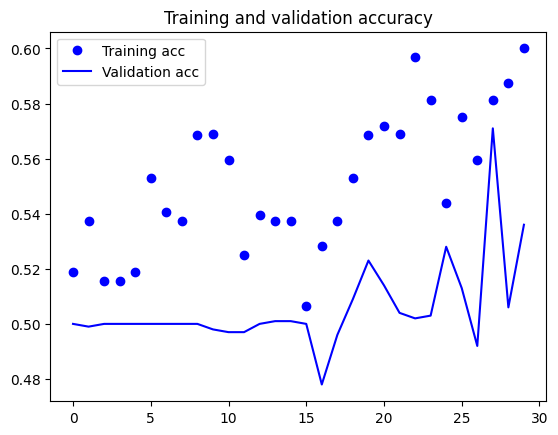

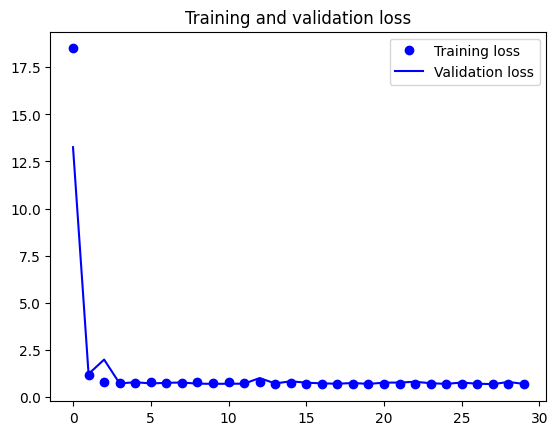

In [40]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 다양한 방법을 사용하여 모델의 성능 올리기

배치 사이즈: 16 -> 32
Epoch : 5 -> 100
rotation: 0.3 -> 0.1
step_per_epoch: 기존 -> 10

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
print(path_to_zip)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
path


train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)


# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)


# 학습 이미지 제너레이터
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.1,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)


# 제너레이터 관련 매개변수
batch_size = 32   # 16 -> 32
IMG_HEIGHT = 256
IMG_WIDTH  = 256


# 학습용 이미지 제너레이터 생성
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')    # cats, dogs


# 검증용 이미지 제너레이터 설계
image_gen_val = ImageDataGenerator(rescale=1./255)

# 검증용 이미지 제너레이터 생성
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')


input_layer=tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))


conv1=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
conv2=tf.keras.layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(conv1)
conv2=tf.keras.layers.BatchNormalization()(conv2)
max1=tf.keras.layers.MaxPool2D((2, 2))(conv2)


conv3=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(max1)
conv4=tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(conv3)
conv4=tf.keras.layers.BatchNormalization()(conv4)
max2=tf.keras.layers.MaxPool2D((2, 2))(conv4)


conv5=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(max2)
conv6=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv5)
conv7=tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(conv6)
conv7=tf.keras.layers.BatchNormalization()(conv7)
max3=tf.keras.layers.MaxPool2D((2, 2))(conv7)


conv8=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(max3)
conv9=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv8)
conv10=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv9)
conv10=tf.keras.layers.BatchNormalization()(conv10)
max4=tf.keras.layers.MaxPool2D((2, 2))(conv10)


conv11=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(max4)
conv12=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv11)
conv13=tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(conv12)
conv13=tf.keras.layers.BatchNormalization()(conv13)
max5=tf.keras.layers.MaxPool2D((2, 2))(conv13)


features=tf.keras.layers.Flatten()(max5)
f4096=tf.keras.layers.Dense(1024, activation='relu')(features)
f4096=tf.keras.layers.Dense(1024, activation='relu')(f4096)
f1000=tf.keras.layers.Dense(512, activation='relu')(f4096)
#f1000=tf.keras.layers.Dropout(0.5)(f1000)
out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(f1000)


model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='convent_from_scratch.h5',
        monitor='val_loss',
        save_best_only=True)
]
# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.


epochs = 100   # 30 -> 100

loss_function = tf.keras.losses.binary_crossentropy
optimizer     = tf.keras.optimizers.RMSprop()
metric        = tf.keras.metrics.binary_accuracy
model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=[metric]
    )


history = model.fit(
      train_data_gen,
      #(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size
      steps_per_epoch = 10,
      epochs=epochs,
      validation_data = val_data_gen,
      callbacks = callbacks,
      validation_freq = 1)

/root/.keras/datasets/cats_and_dogs.zip
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_52 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_53 (Conv2D)          (None, 256, 256, 64)      36928     
                                                        

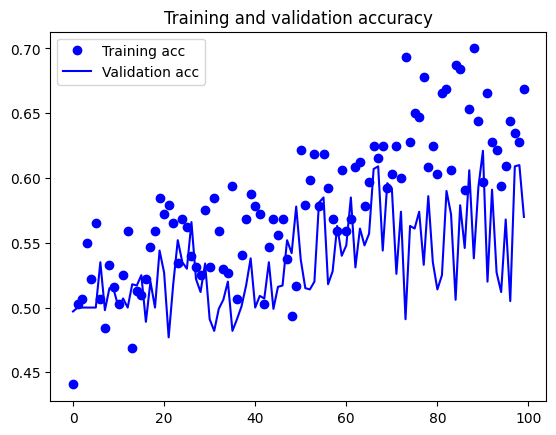

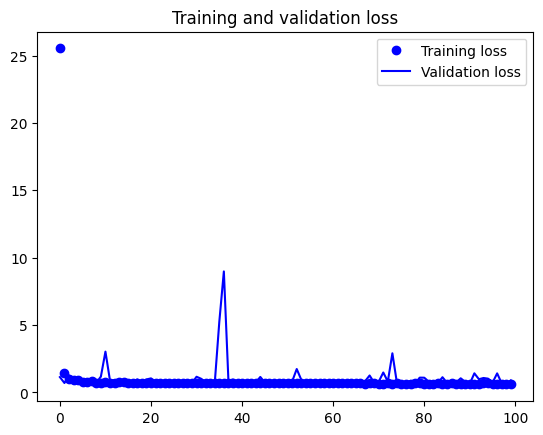

In [42]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#회고

아직 과적합이 일어나지 않았으므로 학습 횟수를 늘리면 더 최적화될 것 같습니다.
다만 이미지의 Batch 크기를 크게하고 학습을 하니 진행이 너무 느리고 기다리는 저도 힘들어서, 이는 추후에 시도하기로 하고 과제는 여기서 마무리하겠습니다.

대규모 모델은 대체 얼마나 많은 시간과 시행착오를 겪어야 하는지...